# Bidirectional Encoder Representations from Transformers (BERT) Notebook

```md
@authors: Grupo 03
```

In [9]:
# Notebook Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import tensorflow as tf
import shutil
import random

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from enum import Enum

In [10]:
# Model run enum
class ModelRunMode(Enum):
    """
    Enumeration of Model Run Mode.
    """
    TRAIN           = "train"           # Train Mode
    CLASSIFY        = "classify"        # Classify Mode

In [11]:
# Model run mode
# Options: 
#   ModelRunMode.TRAIN.value            (Train the model)
#   ModelRunMode.CLASSIFY.value         (Classify data)
mode = ModelRunMode.TRAIN.value
# Prefix for saving the model files
model_prefix = "llm_bert_model"
file_path = "llm_bert_model_weights"
separator_char = "\t"

In [12]:
# Parameters cell
if mode == ModelRunMode.TRAIN.value:
    # TRAIN mode: Set parameters for training
    input_csv = "../tarefa_1/test_input_dataset/merged_inputs.csv"                      # CSV file with training inputs (ID, Text)
    output_csv = "../tarefa_1/test_output_dataset/merged_outputs.csv"                   # CSV file with training outputs (ID, Label)
    test_size = 0.3                                                                     # Proportion of the dataset to use as test data
    random_state=42                                                                     # Seed for reproducible dataset splitting
    seed = 42                                                                           # Global seed for reproducibility across Python, NumPy, and TensorFlow
    os.environ['PYTHONHASHSEED'] = str(seed)                                            # Set environment variable for Python's internal hash seed for determinism
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"                                          # Attempt to force cuDNN to be deterministic
    random.seed(seed)                                                                   # Set Python's built-in random module seed
    np.random.seed(seed)                                                                # Set NumPy random seed
    tf.random.set_seed(seed)                                                            # Set TensorFlow random seed
elif mode == ModelRunMode.CLASSIFY.value:
    # CLASSIFY mode: Set parameters for classification
    input_csv = "classify_input_datasets/submission3_inputs.csv"                        # CSV file with texts for prediction (ID, Text)
    output_csv = "classify_output_datasets/submission3_outputs_llm_bert_model.csv"      # CSV file to store prediction result
else:
    print("The selected option is not valid. Options: \"train\" or \"classify\"!")
    SystemExit()

In [13]:
# Method to load and merge two datasets by ID column
def merge_data_by_id(input_csv, output_csv, sep="\t"):
    df_in = pd.read_csv(input_csv, sep=sep)
    df_out = pd.read_csv(output_csv, sep=sep)

    # Remove duplicates or NaNs if needed
    df_in.dropna(subset=["ID", "Text"], inplace=True)
    df_out.dropna(subset=["ID", "Label"], inplace=True)
    df_in.drop_duplicates(subset=["ID"], inplace=True)
    df_out.drop_duplicates(subset=["ID"], inplace=True)

    df_merged = pd.merge(df_in, df_out, on="ID", how="inner")
    return df_merged

# Method for text cleaning
def text_cleaning(text, stopwords = False):
    def normalize(text):
        # Convert to lowercase
        text = text.lower()
        # Remove numbers, special characters, e o caractere '
        text = re.sub(r"[^a-z\s]", "", text)
        # Replace multiple spaces with a single space
        text = re.sub(r'\s+', ' ', text).strip()
        # Add start and end sequence tokens
        # text = 'startseq ' + " ".join([word for word in text.split() if len(word) > 1]) + ' endseq'
        return text

    def remove_stopwords(text):
        stopwords = [
        "the", "of", "and", "in", "to", "is", "a", "that", "for", "are", "on", "with", 
        "as", "at", "by", "from", "this", "it", "an", "be", "or", "which", "was", "were"
        ]
        text = ' '.join([word for word in text.split() if word not in stopwords])
        return text
    
    text = normalize(text)
    if stopwords:
        text = remove_stopwords(text)
    return text

# Method to convert labels to binary
def convert_labels_to_binary_and_text(df_merged):
    df_merged["Label"] = df_merged["Label"].str.lower().str.strip()
    y = np.where(df_merged["Label"] == "ai", 1, 0)
    texts = df_merged["Text"].tolist()
    return y, texts

# Method to plot the learning curves
def plot_learning_curves(history):
    # Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.show()

# Method to check label distribution
def check_label_distribution(df_merged):
    label_counts = df_merged["Label"].value_counts(dropna=False)
    print("Label distribution:\n", label_counts)

# Method to print the first 5 cleaned texts
def debug_text_cleaning(df_merged):
    for i in range(min(5, len(df_merged))):
        print(df_merged["Text"].iloc[i])

In [ ]:
def train_bert(input_csv, output_csv, model_ckpt="bert-base-uncased", output_dir=file_path, model_prefix=model_prefix, num_train_epochs=3, batch_size=8, test_size=0.2, learning_rate=1e-3, random_state=48):
    print("[INFO] Loading data...")
    df_merged = merge_data_by_id(input_csv, output_csv, sep=separator_char)
    
    print("[INFO] Checking label distribution...")
    check_label_distribution(df_merged=df_merged)
    
    print("[INFO] Cleaning text...")
    df_merged["Text"] = df_merged["Text"].apply(text_cleaning)
    
    print("[INFO] Debugging cleaned text...")
    debug_text_cleaning(df_merged)
    
    print("[INFO] Converting labels and text...")
    labels, texts = convert_labels_to_binary_and_text(df_merged)
    
    print("[INFO] Splitting dataset...")
    X_train_texts, X_val_texts, y_train, y_val = train_test_split(texts, labels, test_size=test_size, random_state=random_state, stratify=labels)
    
    print("[INFO] Initializing tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    
    print("[INFO] Calculating token lengths...")
    raw_train_encodings = tokenizer(X_train_texts, add_special_tokens=True, truncation=False, padding=False)
    token_lengths = [len(seq) for seq in raw_train_encodings["input_ids"]]
    max_length = int(np.percentile(token_lengths, 90))
    print(f"[INFO] Selected max_length: {max_length}")
    
    print("[INFO] Tokenizing train and validation datasets...")
    train_encodings = tokenizer(X_train_texts, truncation=True, padding="max_length", max_length=max_length)
    val_encodings = tokenizer(X_val_texts, truncation=True, padding="max_length", max_length=max_length)
    
    print("[INFO] Converting data to TensorFlow datasets...")
    train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val)).batch(batch_size)
    
    print("[INFO] Loading model...")
    model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=1)
    
    print("[INFO] Compiling model...")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    
    print("[INFO] Setting up early stopping...")
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    
    print("[INFO] Starting training...")
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_train_epochs, callbacks=[early_stopping])
    
    print("[INFO] Evaluating model...")
    val_loss, val_acc = model.evaluate(val_dataset)
    print(f"\n[RESULT] Validation Accuracy: {val_acc:.4f} | Validation Loss: {val_loss:.4f}")
    
    print("[INFO] Model summary:")
    model.summary()
    
    print("[INFO] Plotting learning curves...")
    plot_learning_curves(history)

    # Get predictions from the best model on the validation set
    outputs = model.predict(val_dataset)

    if isinstance(outputs, dict) and "logits" in outputs:
        logits = outputs["logits"]
    else:
        logits = outputs
    
    # Convert logits to probabilities
    probs = tf.nn.sigmoid(logits).numpy()
    
    # Threshold => "AI" vs "Human"
    pred_bin = (probs >= 0.5).astype(int)

    # Calculate the F1 score
    f1 = f1_score(y_val, pred_bin)

    # Calculate the recall score
    recall = recall_score(y_val, pred_bin)

    # Calculate the precision score
    precision = precision_score(y_val, pred_bin)

    # Compute the confusion matrix
    cm = confusion_matrix(y_val, pred_bin)

    # Print the calculated metrics
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print("Confusion Matrix:\n", cm)
    
    print("[INFO] Preparing to save model...")
    if os.path.exists(output_dir):
        print("[INFO] Removing existing output directory...")
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)
    
    model_path = os.path.join(output_dir, f"{model_prefix}_model")
    tokenizer_path = os.path.join(output_dir, f"{model_prefix}_tokenizer")
    config_path = os.path.join(output_dir, f"{model_prefix}_config.json")
    
    print("[INFO] Saving model...")
    model.save_pretrained(model_path)
    
    print("[INFO] Saving tokenizer...")
    tokenizer.save_pretrained(tokenizer_path)
    
    print("[INFO] Saving configuration...")
    config_data = {
        "model_ckpt": model_ckpt,
        "num_train_epochs": num_train_epochs,
        "batch_size": batch_size,
        "max_length": max_length
    }
    with open(config_path, "w") as f:
        json.dump(config_data, f)
    
    print(f"[INFO] Training completed. Model, tokenizer, and config saved to {output_dir}!")


In [15]:
# Classification function
def classify_bert(input_csv, output_csv, output_dir="llm_bert_model_weights", separator_char=separator_char):
    # Construct the file paths
    model_path = os.path.join(output_dir, f"{model_prefix}_model")
    tokenizer_path = os.path.join(output_dir, f"{model_prefix}_tokenizer")
    config_path = os.path.join(output_dir, f"{model_prefix}_config.json")

    # Load the model
    print(f"Loading model from: {output_dir}")
    model = TFAutoModelForSequenceClassification.from_pretrained(model_path)
    
    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

    # Loading configuration
    print("Loading configuration from:", config_path)
    with open(config_path, "r") as f:
         config_data = json.load(f)

    # Retrieve the saved configuration max_len
    max_length = config_data["max_length"]

    # Read the input CSV
    df_input = pd.read_csv(input_csv, sep=separator_char)
    if "ID" not in df_input.columns or "Text" not in df_input.columns:
        raise ValueError("Input CSV must have 'ID' and 'Text' columns for classification.")
    
    # Extract texts
    texts = df_input["Text"].astype(str).tolist()
    
    # Tokenize
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
    
    # Create tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices(dict(encodings))
    dataset = dataset.batch(16)
    
    # Predict probabilities (logits => sigmoid)
    outputs = model.predict(dataset)

    if isinstance(outputs, dict) and "logits" in outputs:
        logits = outputs["logits"]
    else:
        logits = outputs
    
    # Convert logits to probabilities
    probs = tf.nn.sigmoid(logits).numpy()
    
    # Threshold => "AI" vs "Human"
    pred_bin = (probs >= 0.5).astype(int)
    pred_labels = ["AI" if val == 1 else "Human" for val in pred_bin]

    # Save result
    df_out = pd.DataFrame({"ID": df_input["ID"], "Label": pred_labels})
    df_out.to_csv(output_csv, sep=separator_char, index=False)
    print(f"Predictions saved to {output_csv}")

    # Load the validation dataset
    df_true = pd.read_csv("../tarefa_1/validation_dataset/dataset3_disclosed_output.csv", sep="\t")

    # Merge the datasets on the "ID" column, adding suffixes to distinguish the identical column names
    df_merged = pd.merge(df_true, df_out, on="ID", suffixes=('_true', '_pred'))

    # Calculate the number of correct predictions by comparing the "Label" columns
    num_correct = (df_merged["Label_true"] == df_merged["Label_pred"]).sum()

    # Calculate the percentage of correct predictions
    accuracy_percentage = (num_correct / len(df_merged)) * 100

    print(f"Accuracy: {accuracy_percentage:.2f}%")


Tensorflow List of GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[INFO] Loading data...
[INFO] Checking label distribution...
Label distribution:
 Label
Human    942
AI       942
Name: count, dtype: int64
[INFO] Cleaning text...
[INFO] Debugging cleaned text...
we present a general numerical scheme for the practical implementation of statistical moment closures suitable for modeling complex largescale nonlinear systems building on recently developed equationfree methods this approach numerically integrates the closure dynamics the equations of which may not even be available in closed form although closure dynamics introduce statistical assumptions of unknown validity they can have significant computational advantages as they typically have fewer degrees of freedom and may be much less stiff than the original detailed model the closure method can in principle be applied to a wide class of nonlinear problems including stronglycoupled systems either determinist

c:\Users\Eduardo\anaconda3\envs\tf_gpu\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[INFO] Calculating token lengths...
[INFO] Selected max_length: 153
[INFO] Tokenizing train and validation datasets...
[INFO] Converting data to TensorFlow datasets...
[INFO] Loading model...


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Compiling model...
[INFO] Setting up early stopping...
[INFO] Starting training...
Epoch 1/5
165/165 [==============================] - 53s 244ms/step - loss: 0.2092 - accuracy: 0.9059 - val_loss: 0.0743 - val_accuracy: 0.9629
Epoch 2/5
165/165 [==============================] - 37s 223ms/step - loss: 0.0447 - accuracy: 0.9810 - val_loss: 0.0542 - val_accuracy: 0.9788
Epoch 3/5
165/165 [==============================] - 36s 221ms/step - loss: 0.0252 - accuracy: 0.9909 - val_loss: 0.0718 - val_accuracy: 0.9770
Epoch 4/5
165/165 [==============================] - 37s 224ms/step - loss: 0.0060 - accuracy: 0.9992 - val_loss: 0.0823 - val_accuracy: 0.9770
[INFO] Evaluating model...
71/71 [==============================] - 5s 73ms/step - loss: 0.0542 - accuracy: 0.9788

[RESULT] Validation Accuracy: 0.9788 | Validation Loss: 0.0542
[INFO] Model summary:
Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)       

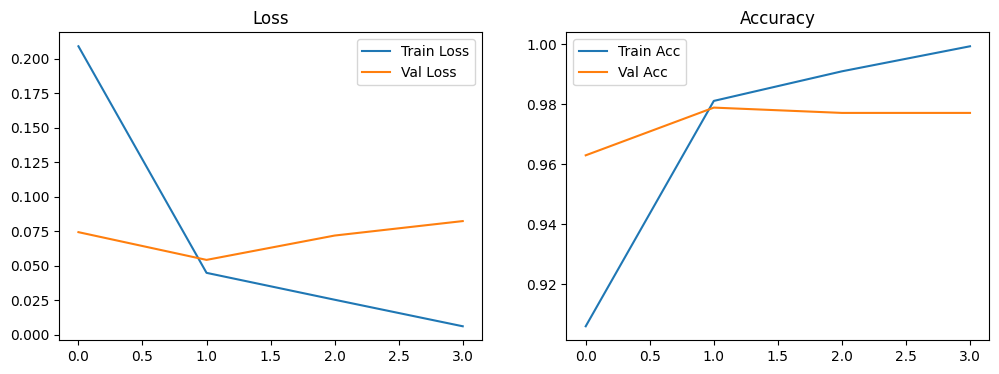

71/71 [==============================] - 7s 70ms/step
F1 Score: 0.9821
Recall: 0.9717
Precision: 0.9928
Confusion Matrix:
 [[281   2]
 [  8 275]]
[INFO] Preparing to save model...
[INFO] Saving model...
[INFO] Saving tokenizer...
[INFO] Saving configuration...
[INFO] Training completed. Model, tokenizer, and config saved to llm_bert_model_weights!


In [16]:
if mode == ModelRunMode.TRAIN.value:
    # Check if Tensorflow is listing available GPUs (if not, continue with CPU)
    print("Tensorflow List of GPUs:", tf.config.list_physical_devices('GPU'))
    
    # Train model
    train_bert(input_csv=input_csv, output_csv=output_csv, model_ckpt="bert-base-uncased", output_dir=file_path, model_prefix=model_prefix, num_train_epochs=5, batch_size=8, test_size=test_size, learning_rate=1e-5, random_state=random_state)

if mode == ModelRunMode.CLASSIFY.value:
    # Classification
    classify_bert(input_csv=input_csv, output_csv=output_csv, output_dir=file_path, separator_char=separator_char)